In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import scipy.stats as stats
import seaborn as sns
# Ustawienia stylu wykresów
plt.style.use('seaborn-v0_8-whitegrid') # Lub inny dostępny styl
plt.rcParams['figure.figsize'] = [14, 12]
plt.rcParams['lines.linewidth'] = 1.5

In [ ]:
# Konfiguracja
tikery = ['SPY', 'TLT', 'GLD', 'MSFT', 'JNJ']
start_download = '2016-01-01'
end_download = '2025-12-31'
window_size = 500
rebalance_freq = 5
target_start_date = pd.Timestamp('2019-01-01')
target_end_date = pd.Timestamp('2025-12-31')

In [ ]:
def get_data(tickers, start, end):
    """Pobiera dane i wyrównuje punkty czasowe (inner join)."""
    data = yf.download(tickers, start=start, end=end, progress=False)['Close']
    data = data.dropna()
    returns = data.pct_change().dropna()
    return returns


def minimize_variance_portfolio(cov_matrix):
    """Oblicza wagi dla portfela o minimalnej wariancji."""
    n = len(cov_matrix)

    # Funkcja celu: Wariancja portfela w^T * Sigma * w
    def portfolio_variance(weights):
        return np.dot(weights.T, np.dot(cov_matrix, weights))

    # Ograniczenia
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1}) # Suma wag = 1
    bounds = tuple((0, 1) for _ in range(n)) # Long only (0 <= w <= 1)

    # Inicjalizacja (równoważony)
    init_guess = np.array([1./n for _ in range(n)])

    result = minimize(portfolio_variance, init_guess,
                      method='SLSQP', bounds=bounds, constraints=constraints,
                      options={'ftol': 1e-9, 'maxiter': 1000})


    if not result.success:
        print(f"UWAGA: Optymalizacja nie powiodła się: {result.message}")
        return init_guess

    # Sprawdź czy wagi się różnią od equal weight
    if np.allclose(result.x, init_guess, atol=1e-4):
        print("UWAGA: Wagi są identyczne z equal weight!")

    return result.x

def calculate_metrics(series):
    """Oblicza roczne metryki: Mean, Std, VaR 95%, ES 95%."""
    # Annualizacja przybliżona (252 dni) dla średniej i odchylenia
    ann_factor = 252

    mean_ret = series.mean() * ann_factor
    std_dev = series.std() * np.sqrt(ann_factor)

    # VaR i CVaR liczone na dziennych zwrotach, potem można skalować lub zostawić dzienne
    # Tu prezentujemy dzienne VaR/ES dla precyzji lub roczne dla spójności
    # Dla czytelności tabeli: VaR i ES prezentujemy jako dzienne poziomy ryzyka (standard w risk mgmt)
    # lub roczne stopy. Poniżej: Dzienne %

    var_95 = np.percentile(series, 5)
    es_95 = series[series <= var_95].mean()

    return pd.Series({
        'Ann. Return': mean_ret,
        'Ann. Std Dev': std_dev,
        'Daily VaR (95%)': var_95,
        'Daily ES (95%)': es_95
    })

In [ ]:
print("Pobieranie i przetwarzanie danych...")
returns_df = get_data(tikery, start_download, end_download)

analysis_returns = returns_df.loc[target_start_date:target_end_date]
full_dates = returns_df.index

mvp_returns = pd.Series(index=analysis_returns.index, dtype=float)
weights_history = []

Pobieranie i przetwarzanie danych...


In [ ]:
try:
    start_idx = returns_df.index.get_loc(returns_df[returns_df.index >= target_start_date].index[0])
except IndexError:
    raise ValueError("Brak danych po dacie startowej. Sprawdź zakres pobierania.")

current_idx = start_idx

print(f"Rozpoczęcie symulacji od: {returns_df.index[current_idx]}")

while current_idx < len(returns_df):
    # Definiowanie okna treningowego [t-500 : t]
    train_start = current_idx - window_size

    if train_start < 0:
        current_idx += rebalance_freq
        continue

    train_data = returns_df.iloc[train_start:current_idx]

    # Wyznaczenie macierzy kowariancji
    cov_matrix = train_data.cov().values  # Konwersja do numpy array dla lepszej wydajności

    # Optymalizacja - tutaj był główny błąd
    opt_weights = minimize_variance_portfolio(cov_matrix)
    weights_history.append((returns_df.index[current_idx], opt_weights))

    # Wyznaczenie stóp zwrotu na kolejne dni
    test_end = min(current_idx + rebalance_freq, len(returns_df))
    test_returns = returns_df.iloc[current_idx:test_end]

    # Obliczenie zwrotu portfela
    portfolio_period_ret = test_returns.dot(opt_weights)

    # Zapisanie wyników
    mvp_returns.loc[portfolio_period_ret.index] = portfolio_period_ret

    # Przesunięcie okna
    current_idx += rebalance_freq

Rozpoczęcie symulacji od: 2019-01-02 00:00:00


In [ ]:
mvp_returns = mvp_returns.dropna()

# 3. Portfel Równoważony (Equal Weight)
n_assets = len(tikery)
ew_weights = np.array([1/n_assets] * n_assets)
ew_returns = analysis_returns.dot(ew_weights)

# 4. Agregacja wyników (MVP, EW, Poszczególne aktywa)
all_strategies = analysis_returns.copy()
all_strategies['MVP'] = mvp_returns
all_strategies['EqualWeight'] = ew_returns


### Roczne Stopy Zwrotu (CAGR) ###
------------------------------------------------------------
Strategy       MVP  EqualWeight       GLD       JNJ      MSFT       SPY  \
Year                                                                      
2019.0    0.175326     0.245713  0.171107  0.163955  0.474615  0.279694   
2020.0    0.193289     0.250045  0.239841  0.147843  0.449453  0.223804   
2021.0    0.029867     0.150715 -0.033012  0.118805  0.444231  0.261073   
2022.0   -0.126572    -0.143560  0.003835  0.073310 -0.267857 -0.172025   
2023.0    0.064531     0.166771  0.129381 -0.076795  0.493862  0.242983   
2024.0    0.084191     0.101526  0.247678 -0.037954  0.141590  0.230216   
2025.0    0.284735     0.274080  0.525474  0.412512  0.183693  0.191424   

Strategy       TLT  
Year                
2019.0    0.139193  
2020.0    0.189286  
2021.0   -0.037521  
2022.0   -0.355062  
2023.0    0.044423  
2024.0   -0.073901  
2025.0    0.057296  

### Roczne Odchylenie Standardowe (Ry

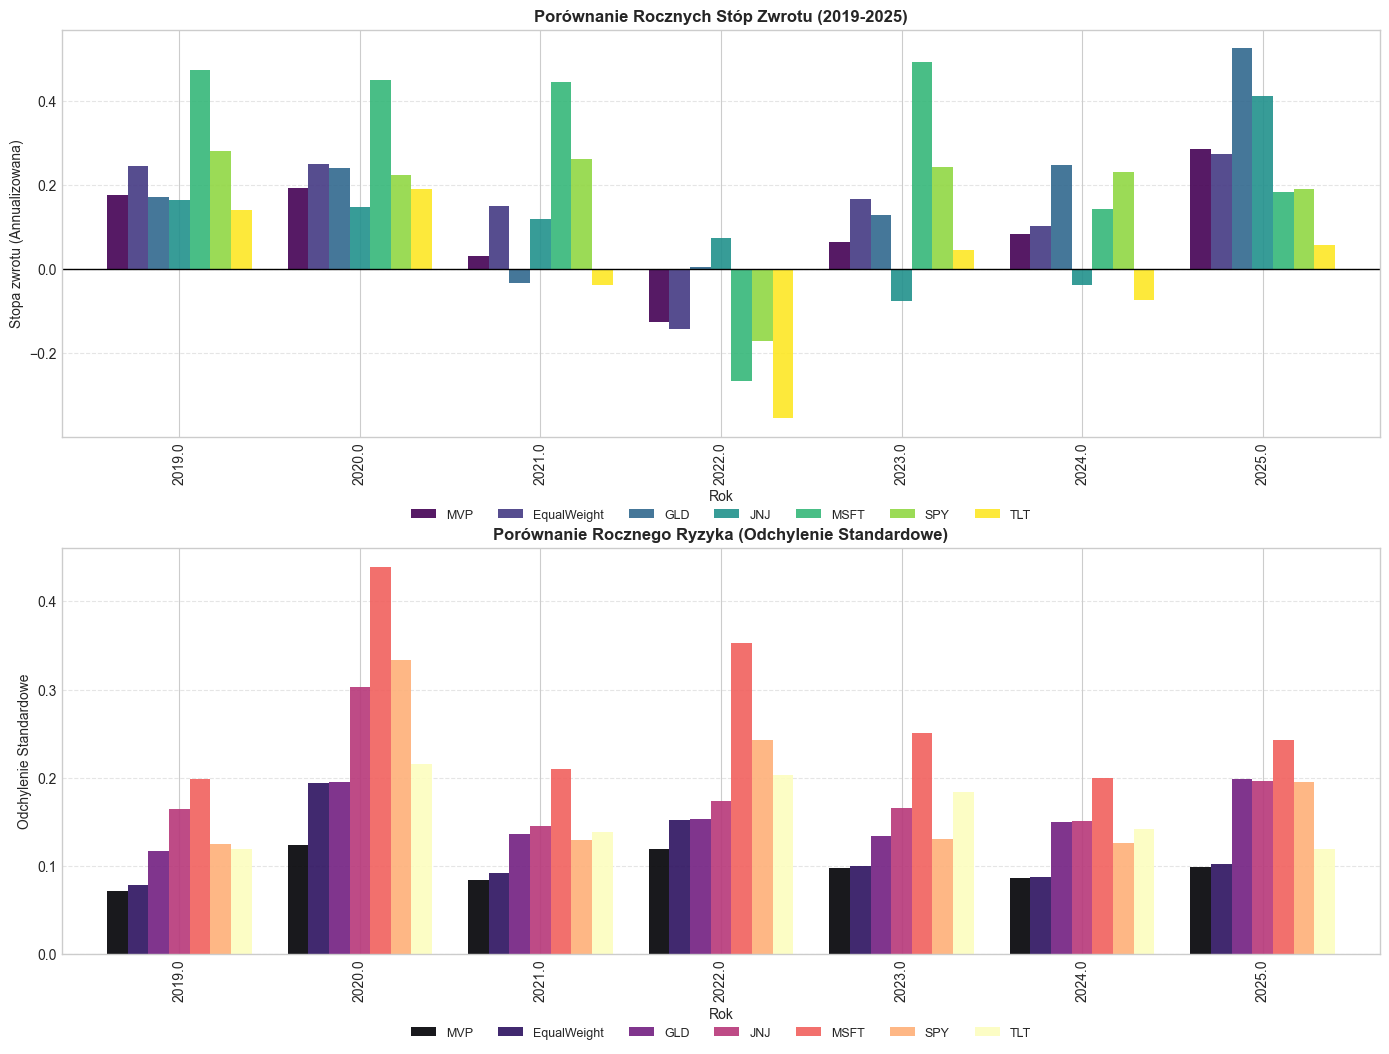

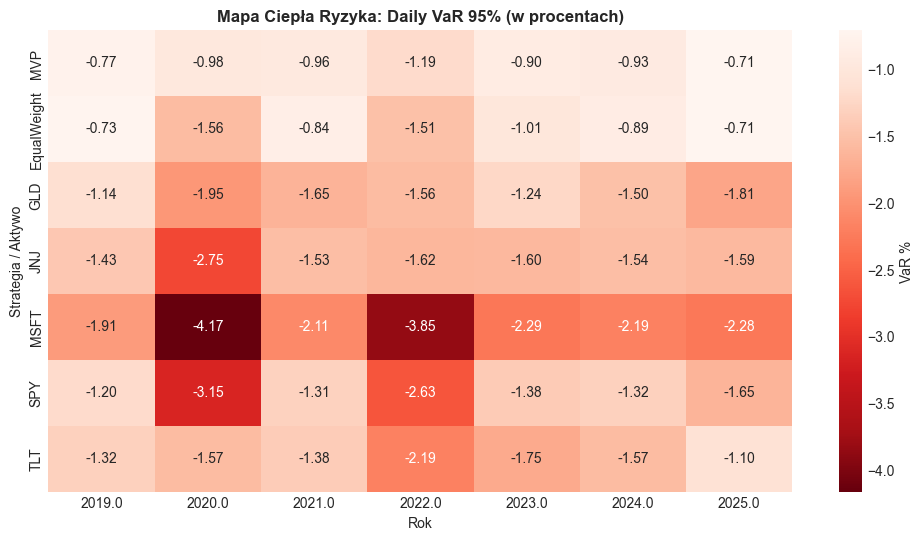

In [ ]:
# 5. Analiza roczna
years = all_strategies.index.year.unique()
results_list = []

for year in years:
    subset = all_strategies[all_strategies.index.year == year]
    if subset.empty: continue

    for col in subset.columns:
        metrics = calculate_metrics(subset[col])
        metrics['Year'] = year
        metrics['Strategy'] = col
        results_list.append(metrics)

results_df = pd.DataFrame(results_list)
pivots = {}
metrics_map = {
    'Ann. Return': 'Roczne Stopy Zwrotu (CAGR)',
    'Ann. Std Dev': 'Roczne Odchylenie Standardowe (Ryzyko)',
    'Daily VaR (95%)': 'Dzienne Value at Risk (95%)',
    'Daily ES (95%)': 'Dzienny Expected Shortfall (95%)'
}

for metric, title in metrics_map.items():
    # Tworzenie tabeli przestawnej dla danej metryki
    table = results_df.pivot(index='Year', columns='Strategy', values=metric)

    # Sortowanie kolumn, aby MVP i EqualWeight były pierwsze
    cols = ['MVP', 'EqualWeight'] + [c for c in table.columns if c not in ['MVP', 'EqualWeight']]
    table = table[cols]

    pivots[metric] = table

    print(f"\n### {title} ###")
    print("-" * 60)
    print(table)

# 2. Wizualizacja Graficzna (Bar Charts)
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 1, figsize=(14, 12))

# Wykres 1: Roczne Stopy Zwrotu
ax1 = axes[0]
pivots['Ann. Return'].plot(kind='bar', ax=ax1, width=0.8, colormap='viridis', alpha=0.9)

ax1.set_title('Porównanie Rocznych Stóp Zwrotu (2019-2025)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Stopa zwrotu (Annualizowana)')
ax1.set_xlabel('Rok')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7, fontsize=9)
ax1.axhline(0, color='black', linewidth=1)
ax1.grid(axis='y', linestyle='--', alpha=0.5)

# Wykres 2: Roczne Ryzyko (Odchylenie Standardowe)
ax2 = axes[1]
pivots['Ann. Std Dev'].plot(kind='bar', ax=ax2, width=0.8, colormap='magma', alpha=0.9)

ax2.set_title('Porównanie Rocznego Ryzyka (Odchylenie Standardowe)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Odchylenie Standardowe')
ax2.set_xlabel('Rok')
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=7, fontsize=9)
ax2.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
plt.show()

# 3. Wizualizacja "Ogonów" - VaR i ES (Heatmapa)
# Heatmapa jest lepsza do porównywania wielu liczb niż wykres słupkowy w tym przypadku
plt.figure(figsize=(12, 6))
sns.heatmap(pivots['Daily VaR (95%)'].T * 100, annot=True, fmt=".2f", cmap="Reds_r", cbar_kws={'label': 'VaR %'})
plt.title('Mapa Ciepła Ryzyka: Daily VaR 95% (w procentach)', fontsize=12, fontweight='bold')
plt.xlabel('Rok')
plt.ylabel('Strategia / Aktywo')
plt.show()

In [ ]:
# Dodatkowo: Podsumowanie całego okresu
print("\n--- PODSUMOWANIE CAŁEGO OKRESU (2019-2025) ---")
total_metrics = []
for col in all_strategies.columns:
    m = calculate_metrics(all_strategies[col])
    m.name = col
    total_metrics.append(m)

print(pd.DataFrame(total_metrics))


--- PODSUMOWANIE CAŁEGO OKRESU (2019-2025) ---
             Ann. Return  Ann. Std Dev  Daily VaR (95%)  Daily ES (95%)
GLD             0.183085      0.157538        -0.015720       -0.022708
JNJ             0.114277      0.192225        -0.016423       -0.027414
MSFT            0.274539      0.283659        -0.026971       -0.039761
SPY             0.179728      0.197790        -0.017667       -0.029974
TLT            -0.005037      0.164725        -0.016443       -0.022242
MVP             0.100676      0.098995        -0.009665       -0.013635
EqualWeight     0.149318      0.121747        -0.010800       -0.017240


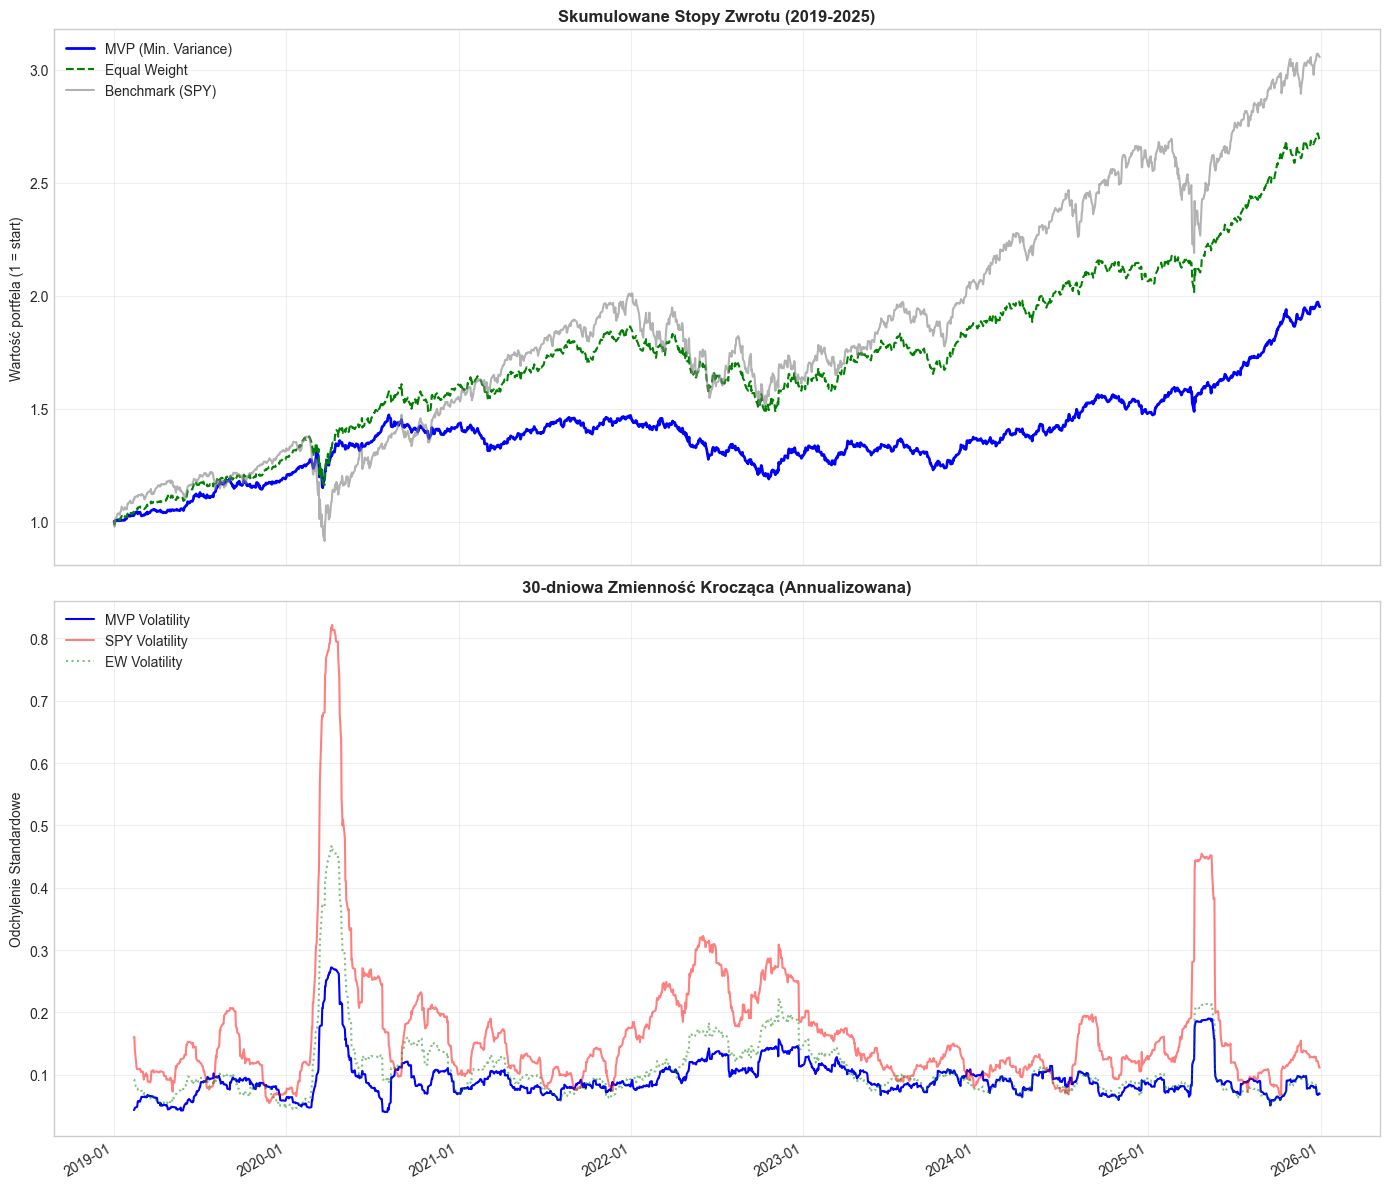

In [ ]:
weights_dates = [x[0] for x in weights_history]
weights_values = [x[1] for x in weights_history]
weights_df = pd.DataFrame(weights_values, index=weights_dates, columns=tikery)

# Wyrównanie indeksu wag do codziennego (ffill - wagi stałe przez 5 dni)
weights_daily = weights_df.reindex(all_strategies.index).ffill()

# Obliczenie skumulowanych zwrotów (Equity Curve)
cumulative_returns = (1 + all_strategies).cumprod()

# Obliczenie 30-dniowej zmienności kroczącej (rocznej)
rolling_vol = all_strategies.rolling(window=30).std() * np.sqrt(252)

# --- TWORZENIE WYKRESÓW ---
fig, axes = plt.subplots(2, 1, sharex=True)

# Wykres 1: Skumulowane stopy zwrotu
ax1 = axes[0]
ax1.plot(cumulative_returns.index, cumulative_returns['MVP'], label='MVP (Min. Variance)', color='blue', linewidth=2)
ax1.plot(cumulative_returns.index, cumulative_returns['EqualWeight'], label='Equal Weight', color='green', linestyle='--')
ax1.plot(cumulative_returns.index, cumulative_returns['SPY'], label='Benchmark (SPY)', color='gray', alpha=0.6)

ax1.set_title('Skumulowane Stopy Zwrotu (2019-2025)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Wartość portfela (1 = start)')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# Wykres 2: Zmienność krocząca (Ryzyko)
ax2 = axes[1]
ax2.plot(rolling_vol.index, rolling_vol['MVP'], label='MVP Volatility', color='blue')
ax2.plot(rolling_vol.index, rolling_vol['SPY'], label='SPY Volatility', color='red', alpha=0.5)
ax2.plot(rolling_vol.index, rolling_vol['EqualWeight'], label='EW Volatility', color='green', alpha=0.5, linestyle=':')

ax2.set_title('30-dniowa Zmienność Krocząca (Annualizowana)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Odchylenie Standardowe')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Formatowanie osi daty
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [ ]:
def oblicz_szczegolowe_statystyki(df):
    """Oblicza kompleksowe statystyki opisowe dla stóp zwrotu."""

    statystyki_df = pd.DataFrame(index=df.columns)

    # 1. Momenty centralne (annualizowane tam, gdzie to ma sens)
    statystyki_df['Średnia (roczna)'] = df.mean() * 252
    statystyki_df['Mediana (roczna)'] = df.median() * 252
    statystyki_df['Odchylenie standardowe (roczne)'] = df.std() * np.sqrt(252)

    # 2. Kształt rozkładu (na danych dziennych – nie annualizujemy)
    statystyki_df['Skośność'] = df.skew()
    statystyki_df['Kurtoza'] = df.kurtosis()  # Nadmiarowa kurtoza (rozkład normalny = 0)

    # 3. Test Jarque–Bera na normalność
    # Zwraca statystykę i p-value; jeśli p < 0.05 → odrzucamy normalność
    jb_test = df.apply(lambda x: stats.jarque_bera(x.dropna()))
    statystyki_df['JB p-value'] = jb_test.iloc[1]
    statystyki_df['Czy rozkład normalny?'] = statystyki_df['JB p-value'] > 0.05

    # 4. Ryzyko ekstremalne
    # Maksymalne obsunięcie kapitału (Max Drawdown)
    skumulowane_zwroty = (1 + df).cumprod()
    maksimum_kroczace = skumulowane_zwroty.cummax()
    obsuniecie = (skumulowane_zwroty - maksimum_kroczace) / maksimum_kroczace
    statystyki_df['Maksymalne obsunięcie'] = obsuniecie.min()

    # Wskaźnik Sharpe’a (uprośczenie: stopa wolna od ryzyka = 0)
    statystyki_df['Wskaźnik Sharpe’a'] = (
        statystyki_df['Średnia (roczna)'] /
        statystyki_df['Odchylenie standardowe (roczne)']
    )

    return statystyki_df

# Wykonanie obliczeń
print("Generowanie statystyk opisowych...")
desc_stats = oblicz_szczegolowe_statystyki(all_strategies)

# Wyświetlenie tabeli
print("\n--- SZCZEGÓŁOWE STATYSTYKI OPISOWE (2019-2025) ---")
print(desc_stats.sort_values(by='Odchylenie standardowe (roczne)'))


Generowanie statystyk opisowych...

--- SZCZEGÓŁOWE STATYSTYKI OPISOWE (2019-2025) ---
             Średnia (roczna)  Mediana (roczna)  \
Ticker                                            
MVP                  0.100676          0.141182   
EqualWeight          0.149318          0.159310   
GLD                  0.183085          0.216335   
TLT                 -0.005037          0.068430   
JNJ                  0.114277          0.121758   
SPY                  0.179728          0.249503   
MSFT                 0.274539          0.291561   

             Odchylenie standardowe (roczne)  Skośność    Kurtoza  \
Ticker                                                              
MVP                                 0.098995 -0.142949   3.809546   
EqualWeight                         0.121747  0.045444   8.915023   
GLD                                 0.157538 -0.341539   3.128490   
TLT                                 0.164725  0.163778   4.497028   
JNJ                                 0.1

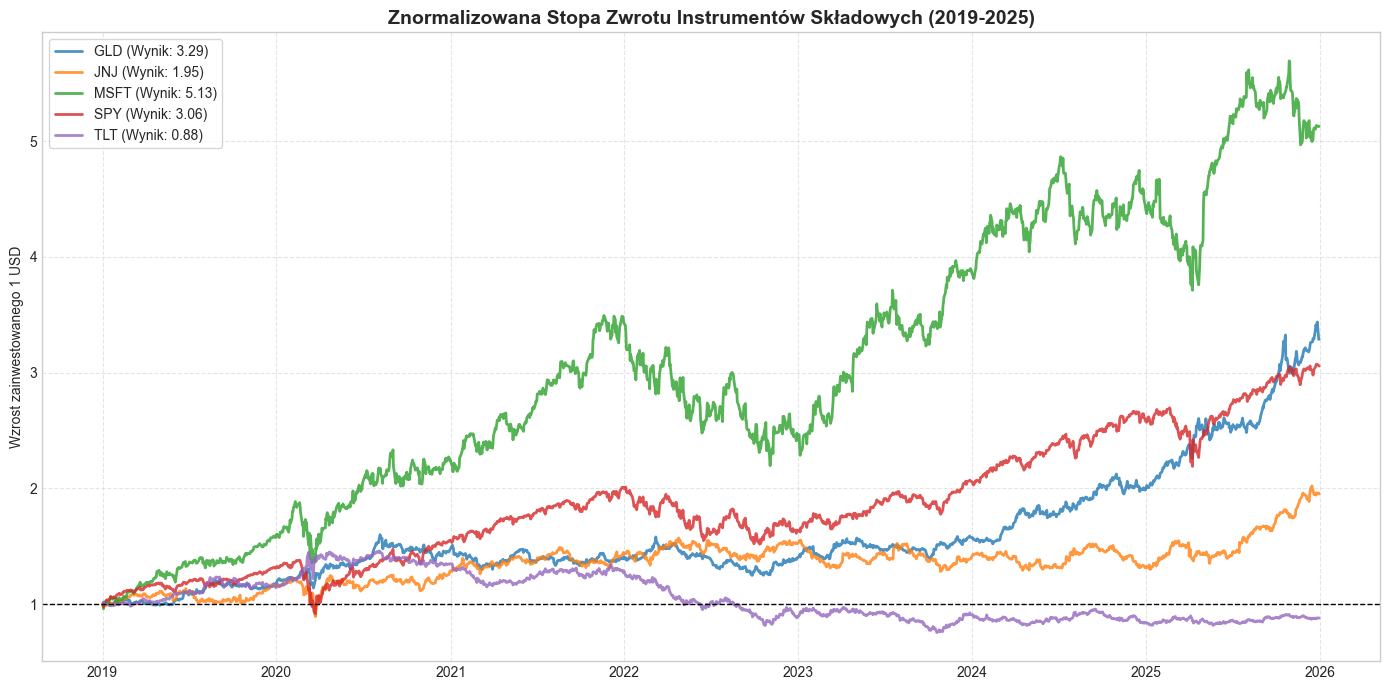

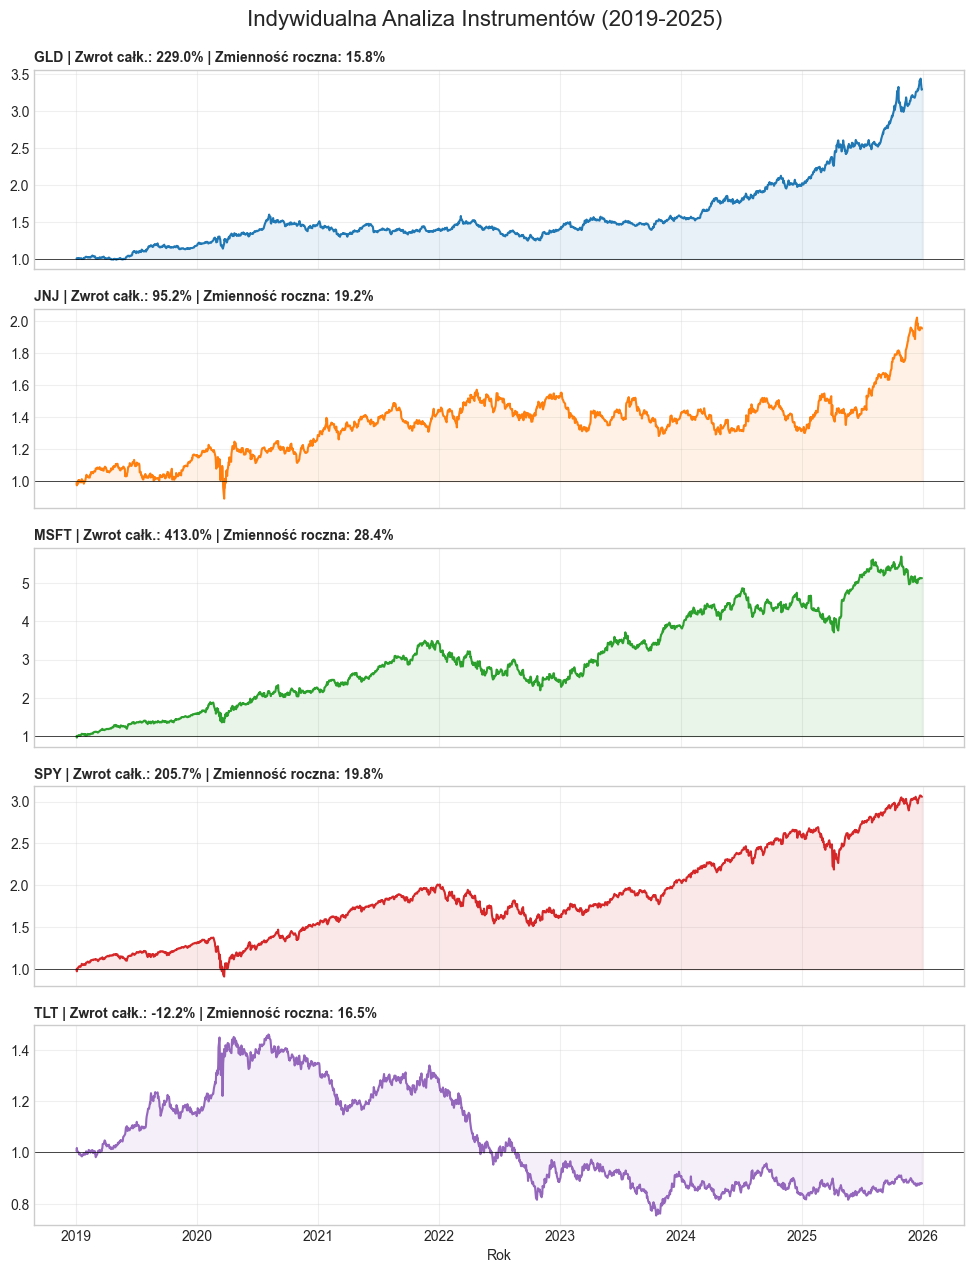

In [ ]:
# Ustawienia estetyczne
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # Kolory dla 5 instrumentów

# Obliczenie skumulowanych zwrotów (Start = 1.0)
component_growth = (1 + analysis_returns).cumprod()

# --- WARIANT 1: Wykres Porównawczy (Wszystko na jednym) ---
plt.figure(figsize=(14, 7))

for i, ticker in enumerate(component_growth.columns):
    # Wyświetlamy ostatnią wartość na legendzie dla szybkiej oceny
    final_val = component_growth[ticker].iloc[-1]
    label_text = f"{ticker} (Wynik: {final_val:.2f})"
    plt.plot(component_growth.index, component_growth[ticker], label=label_text, linewidth=2, alpha=0.8)

plt.title('Znormalizowana Stopa Zwrotu Instrumentów Składowych (2019-2025)', fontsize=14, fontweight='bold')
plt.ylabel('Wzrost zainwestowanego 1 USD')
plt.axhline(1.0, color='black', linestyle='--', linewidth=1) # Linia poziomu 0% zysku
plt.legend(loc='upper left', frameon=True)
plt.grid(True, which='major', linestyle='--', alpha=0.5)

# Formatowanie osi X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.tight_layout()
plt.show()

# --- WARIANT 2: Siatka Wykresów (Indywidualna dynamika) ---
# Pozwala ocenić specyficzną zmienność (szum) każdego aktywa
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True)

for i, ticker in enumerate(component_growth.columns):
    ax = axes[i]
    # Rysowanie linii
    ax.plot(component_growth.index, component_growth[ticker], color=colors[i], label=ticker)

    # Dodanie obszaru pod wykresem dla lepszej czytelności trendu
    ax.fill_between(component_growth.index, component_growth[ticker], 1, color=colors[i], alpha=0.1)

    # Oznaczenie statystyk na wykresie
    total_ret = (component_growth[ticker].iloc[-1] - 1) * 100
    std_dev = analysis_returns[ticker].std() * (252**0.5) * 100

    ax.set_title(f"{ticker} | Zwrot całk.: {total_ret:.1f}% | Zmienność roczna: {std_dev:.1f}%", loc='left', fontsize=10, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.axhline(1.0, color='black', linestyle='-', linewidth=0.5)

fig.suptitle('Indywidualna Analiza Instrumentów (2019-2025)', fontsize=16, y=0.92)
plt.xlabel('Rok')
plt.show()